In this notebook you're going to graph two FTIR spectra, starting with just the raw interferograms output by an FTIR. Why might you want to do this, instead of just using the spectrum the instrument gives you? Turns out there is quite a bit of processing to turn the collected interferogram into a spectrum, and that processing can affect the spectrum in different ways. Because of that, you may want to sometimes have control over the processing, so you can make changes to best present your data.

For this notebook you will also need to get the 75_BG.txt and 75_AIR.txt files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, we need to create the background spectrum. The interferogram for this is a tab-delimited text file that is named "75_BG.txt", which you will need to set the correct path for.

In [2]:
filename = "75_BG.txt"
path = ""
data = pd.read_csv(path+filename, header=None, sep='\t', names=["length","inten"])


If we graph the data in the text file, we find the interferogram, which tells us about how the light is constructively and destructively interfering in the Michelson interferometer. 

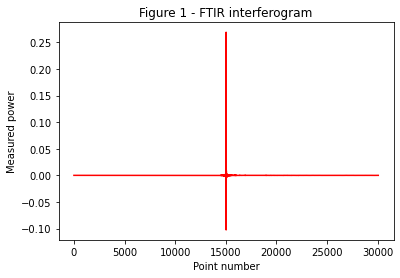

In [3]:
xvals=data['length']
yvals=-data['inten']

plt.plot(xvals,yvals, 'r-')
plt.title("Figure 1 - FTIR interferogram")
plt.xlabel('Point number')
plt.ylabel('Measured power')
plt.show()

At the moment the data is measured intensity (y-axis) and just a number, which isn't very meaningful. We need to first turn the x-axis data into a path length difference between the two paths of the Michelson interferometer. In addition, that big peak around 15000 occurs when the two paths are the same length, i.e. when the path length difference is zero. So we will have to shift all the x-points, and then rescale them. To shift, I'll just make the middle zero, since it looks like the big peak is in the middle.

To rescale, we need to understand the way FTIRs work. They way they work is that they have both white light and a laser shining along the optical path. The white light does all the spectroscopy, while the laser tells the computer when to take a measurement everytime the path length difference is exactly equal to the wavelength of the laser. It does this by activating a switch everytime the laser constructively interferes with itself. In this spectrum a HeNe laser with a wavelength of 633 nm was used, and so each data point corresponds to the path length changing by 633 nm (or 6.33 x 10$^{-5}$ cm).

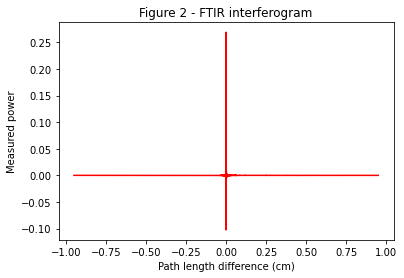

In [4]:
halfpoint = int(xvals.count()/2)
shiftedx = xvals - halfpoint
distanceTraveled = shiftedx * 6.33E-5
plt.plot(distanceTraveled,yvals, 'r-')
plt.title("Figure 2 - FTIR interferogram")
plt.xlabel('Path length difference (cm)')
plt.ylabel('Measured power')
plt.show()

To turn our interferogram into a spectrum, we need to Fourier Transform it. To do that, we will use the Fast Fourier Transform (FFT) algorithm that is built into the numpy package, which is called fft(). Because the Fourier Transform can have complex values, we'll need to also make sure everything is real (so we can graph it). The easiest (*but not the best!*) way to do that is to square the real and imaginary components, add them together, and then take the square root. So let's try it out!

In [5]:
fftdata_inter = np.fft.fft(yvals)
specInten_inter=np.sqrt(fftdata_inter.real**2 + fftdata_inter.imag**2)

What does the Fourier transformed data look like?

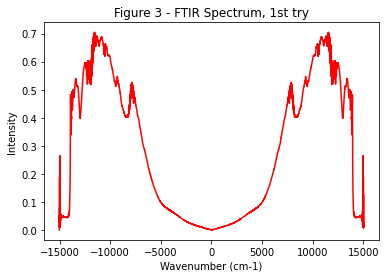

In [6]:
plt.plot(shiftedx,specInten_inter, 'r-')
ax = plt.gca()
plt.title("Figure 3 - FTIR Spectrum, 1st try")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

I guess that sort of looks like a spectrum, but it has some problems. First, the x-axis is weird. It turns out I need to be a little more careful and not use the shifted x-axis I calculated above. Second, the spectrum is symmetric about zero, which an FTIR spectrum shouldn't be. Let's address the second issue first. 

Even though we want to graph our interferogram with the peak in the middle of the graph (i.e. zero path length difference), for post-processing reasons (which I won't get into here) we want to take the Fourier transform with the peak at the beginning. So, we need to find the middle of the peak in the interferogram, and make that the start of the data, then move everything in the interferogram around. Here's what the interferogram looks like after rotating:

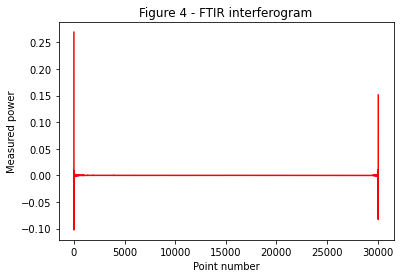

In [7]:
centerMax = yvals.idxmax()
firstHalf = yvals[0:centerMax] 
secondHalf = yvals[centerMax:int(yvals.count())]
rotInten = secondHalf.append(firstHalf, ignore_index=True)

plt.plot(xvals,rotInten, 'r-')
plt.title("Figure 4 - FTIR interferogram")
plt.xlabel('Point number')
plt.ylabel('Measured power')
plt.show()

I can now FFT the interferogram.

In [8]:
fftdata = np.fft.fft(rotInten)
specInten=np.sqrt(fftdata.real**2 + fftdata.imag**2)

Now it's time to address the other issue, which is finding the correct x-axis. This is rather straightforward, as it's essentially just the inverse of the path length difference. The easy way to calculate this is to divide each point corresponding to an x-value by the total path length.

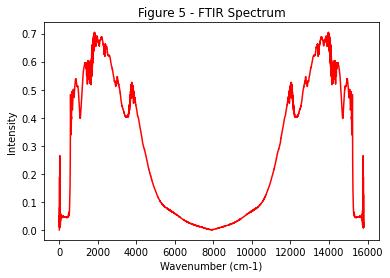

In [9]:
freq = xvals / (xvals.count() * 6.33E-5)
plt.plot(freq, specInten, 'r-')
ax = plt.gca()
plt.title("Figure 5 - FTIR Spectrum")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

That looks a little better, but it's still symmetric. What gives? Because the mirror in the Michelson interferometer moves forwards and backwards (which is why the interferogram is mostly symmetric around zero), when we Fourier Transform the interferogram it will also be a mirror image. Fortunately we can just ignore the second half of the spectrum.

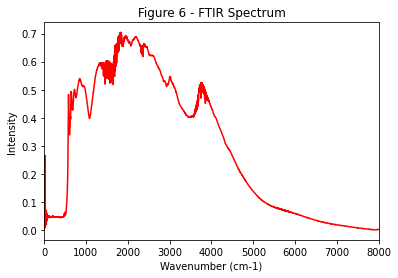

In [10]:
plt.plot(freq, specInten, 'r-')
ax = plt.gca()
ax.set_xlim(0,8000)
plt.title("Figure 6 - FTIR Spectrum")
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.show()

And there we have it, the background spectrum. Now, you graph the spectrum in the second file (75_AIR.txt).

Once you have the spectrum, take the ratio of your spectrum to the background spectrum I graphed, multiply it by 100%, and graph it. This will give you the %T vs. wavenumber.

Regraph the spectrum, zooming in on the area between 3000 and 4000 cm$^{-1}$. 

This is the IR spectrum of a sample of air. Knowing that this is for a gas, how do you explain the  fact that the broad peak in the 3000 to 4000 cm$^{-1}$ range is made up of narrow peaks that can be resolved in this sample? What molecular transitions do these peaks correspond to?

**Answer here**

As I mentioned at the beginning, there is post-processing that we can do to our spectrum. The two most important post-processing steps are apodization, which improves the spectrum resolution, and phase correction, which is the better way to account for the differences between the real and imaginary parts after the FFT. I skipped both of these in this notebook, but I would encourage you to read more about them at [LibreTexts](https://chem.libretexts.org/Textbook_Maps/Analytical_Chemistry/Supplemental_Modules_%28Analytical_Chemistry%29/Instrumental_Analysis/Spectrometer/How_an_FTIR_instrument_works)